In [1]:
%load_ext autoreload
%autoreload 2

from utils.preprocessing import create_time_matrix, create_caregivers_df, create_tasks_df, create_clients_df

caregivers = create_caregivers_df('data/raw/caregivers.csv')

tasks = create_tasks_df('data/raw/hemtjanst_tasks.csv', only_client_tasks=True)

clients = create_clients_df('data/raw/clients.csv')

drive_time_matrix = create_time_matrix('data/raw/duration_matrix_DRIVE.csv')
walk_time_matrix = create_time_matrix('data/raw/duration_matrix_WALK.csv')
bicycle_time_matrix = create_time_matrix('data/raw/duration_matrix_BICYCLE.csv')

In [2]:
# Test1: Subset with only caregivers 33, 949, 1108 and their tasks
test1_subset = [33, 949, 1108]
test_caregivers = caregivers.loc[test1_subset]
test_tasks = tasks[tasks['PlannedCaregiverID'].isin(test1_subset)]
small_test = (test_caregivers, test_tasks)

# Test2: Subset with only first 10 caregivers that use car as mode of transport
car_caregivers = caregivers[caregivers['ModeOfTransport'] == 'car'].head(10)
car_tasks = tasks[tasks['PlannedCaregiverID'].isin(car_caregivers.index)]
car_test = (car_caregivers, car_tasks)

full_test = (caregivers, tasks)

In [ ]:
from models.fixed_model import FixedModel
from models.partition_model import PartitionModel
model_type = FixedModel
model_caregivers, model_tasks = full_test

model = model_type(model_caregivers, model_tasks, clients, drive_time_matrix, walk_time_matrix, bicycle_time_matrix)
model.build()
model.optimize(NoRelHeurWork=120)

Created base variables.
Built base model.
Adding overtime penalties.
Adding caregiver usage penalties.
Adding break requirements.
Updated objective function with penalties.
Set parameter Heuristics to value 0.4
Set parameter NoRelHeurWork to value 120
Set parameter Threads to value 10
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
Heuristics  0.4
NoRelHeurWork  120
Threads  10

Optimize a model with 22034 rows, 3634304 columns and 14517543 nonzeros
Model fingerprint: 0xca13f3ba
Variable types: 96 continuous, 3634208 integer (3634208 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+03]
  Objective range  [1e+00, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 1630 rows and 2189799 columns (presolve time = 5s)...
Presolve removed 1630 rows and 2189799 columns (presolve

<gurobi.Model MIP instance HomeCare: 22034 constrs, 3634304 vars, Parameter changes: Heuristics=0.4, NoRelHeurWork=120.0, Username=(user-defined), LicenseID=2635249, Threads=10>

Model not optimally solved. Status: 11


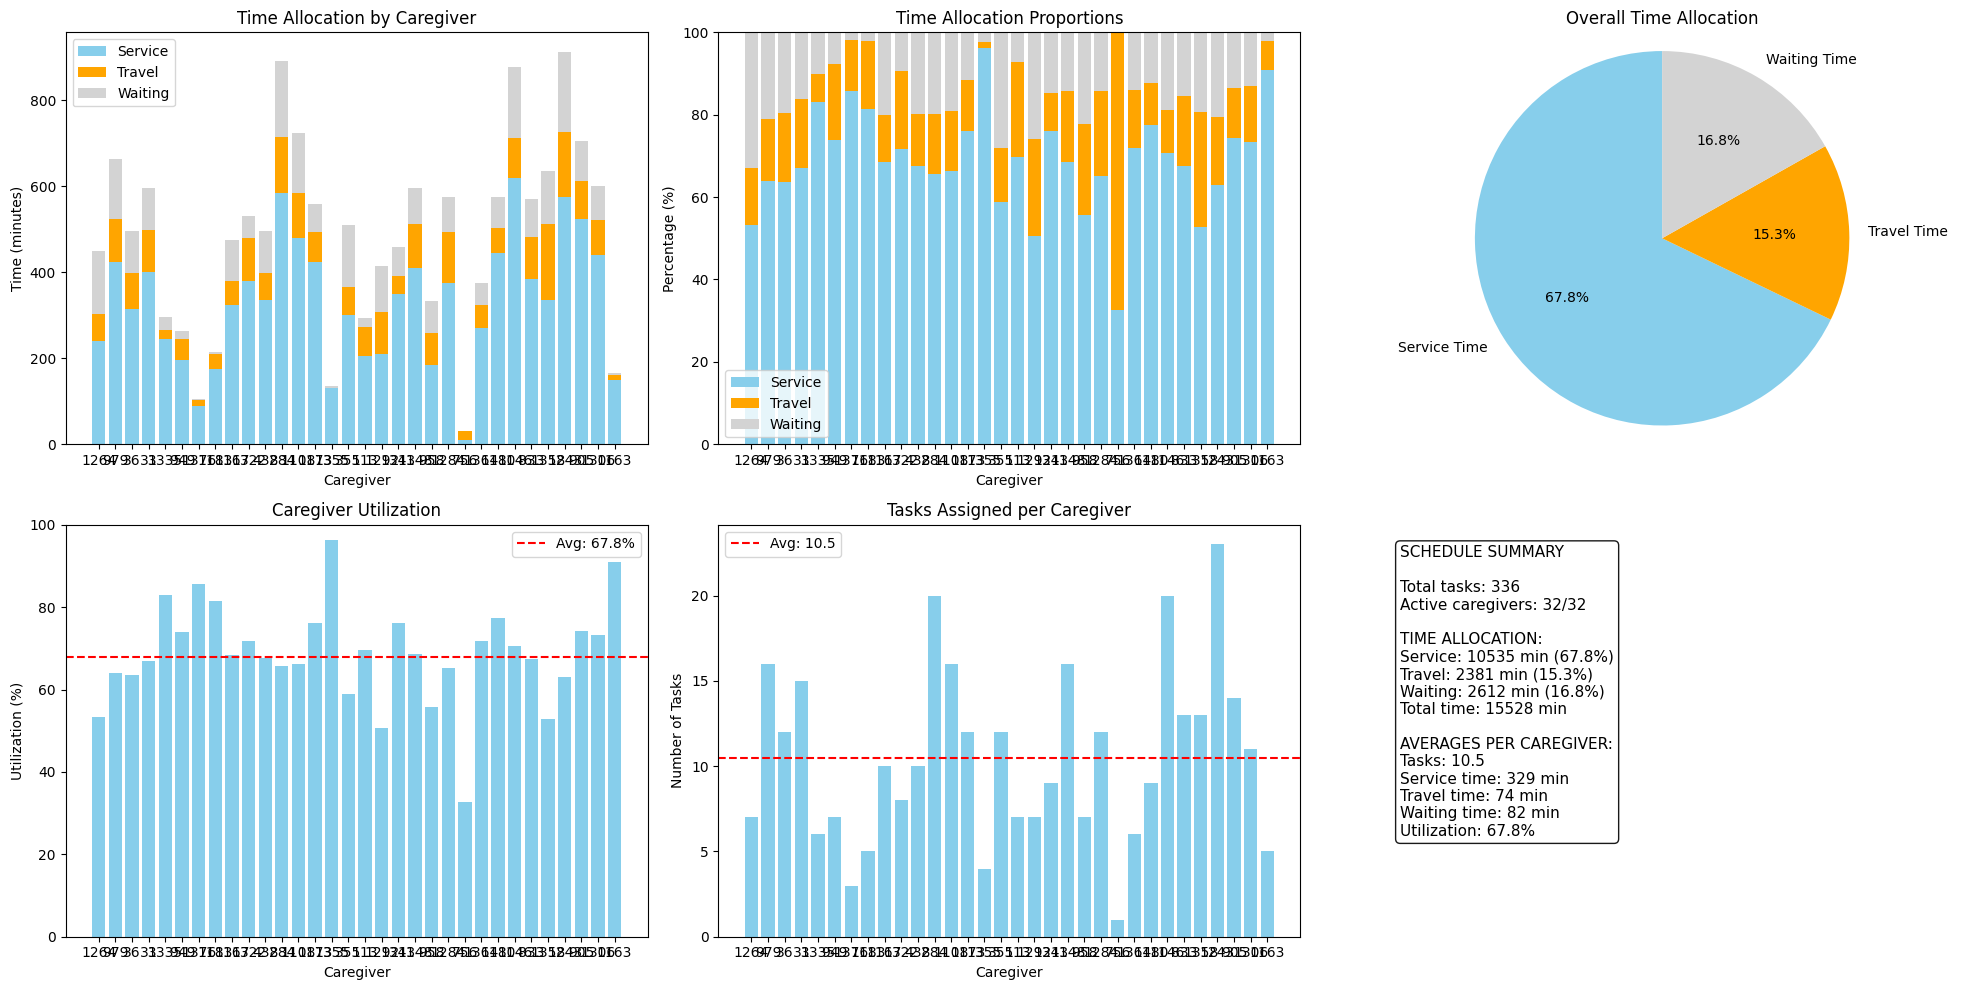

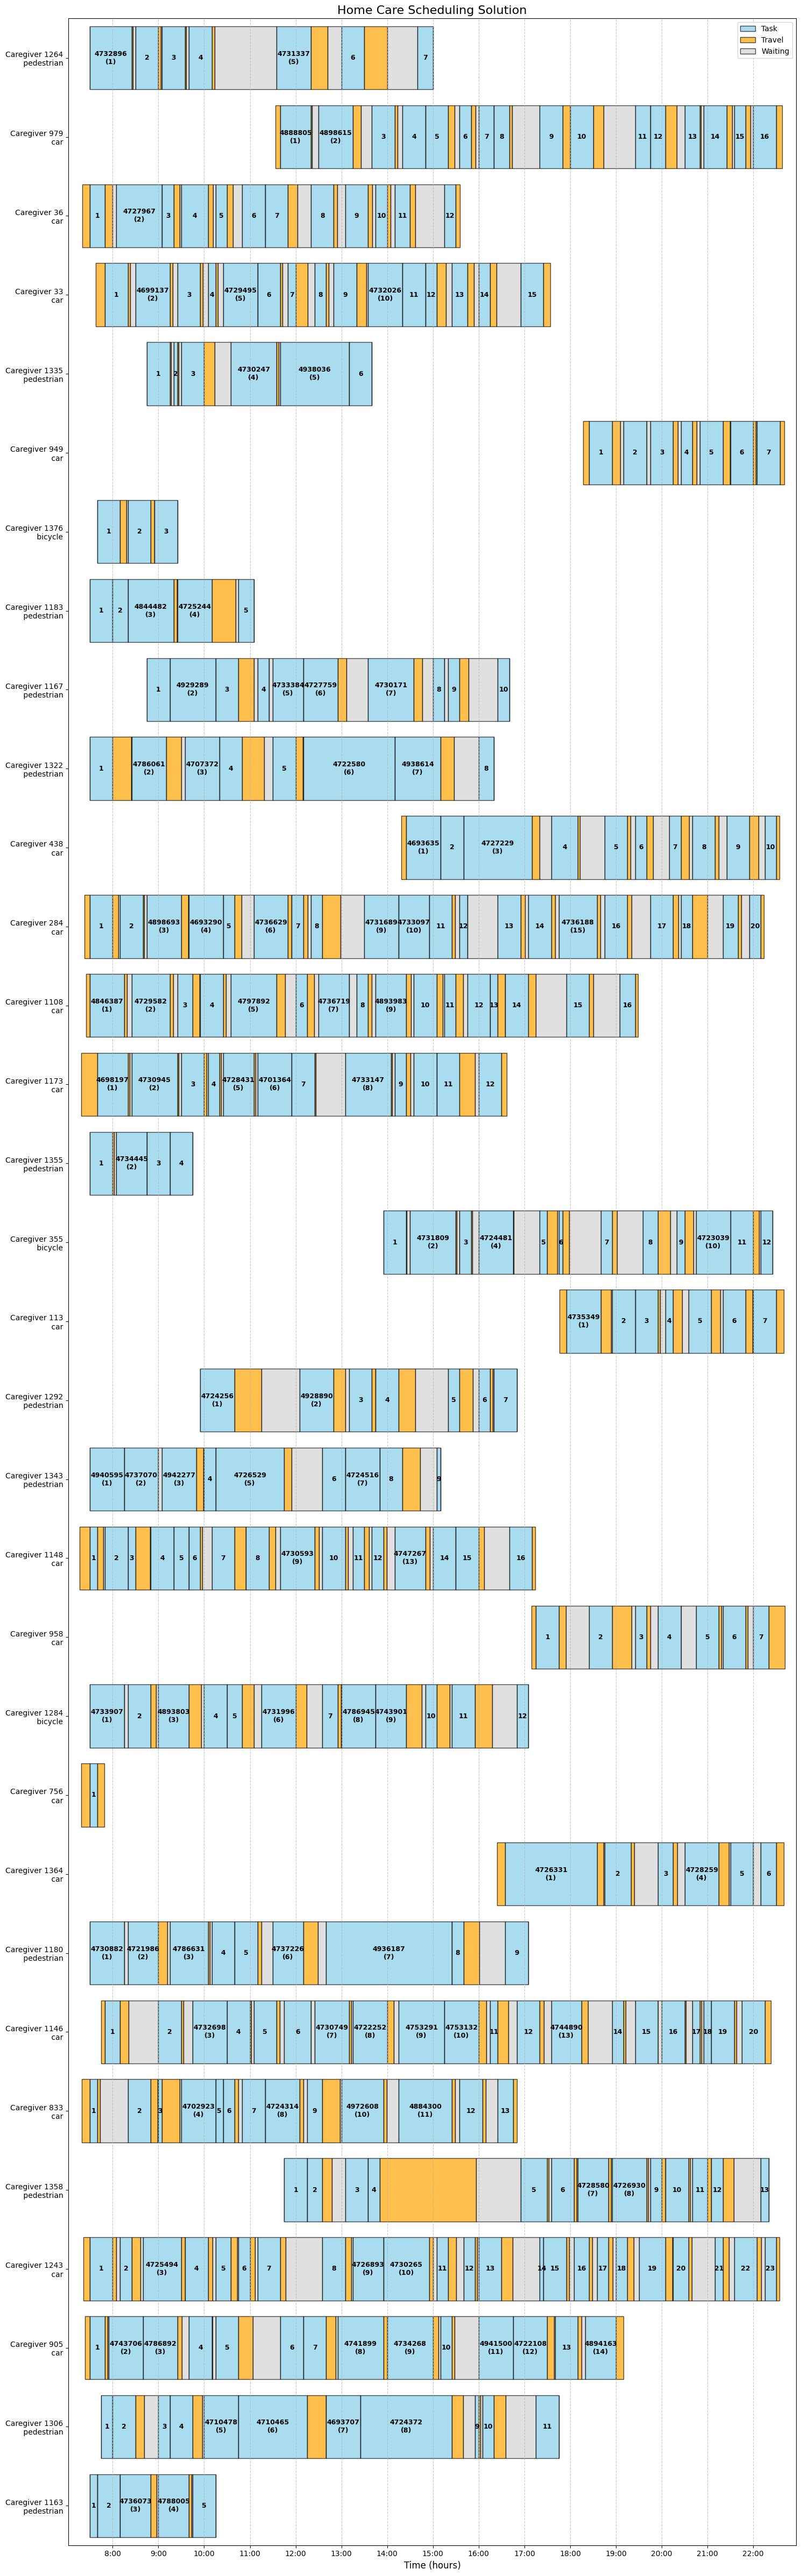

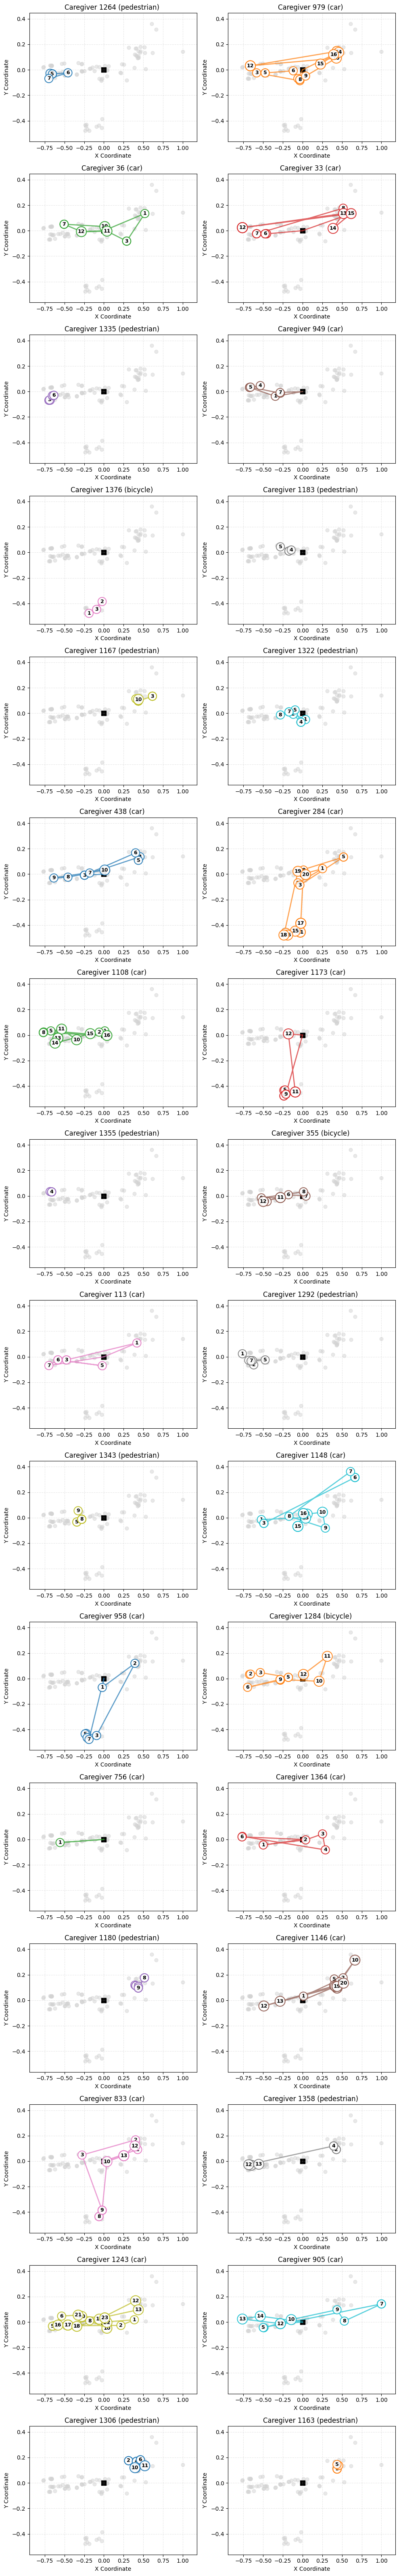

In [5]:
from utils.visualization import visualize_schedule, visualize_metrics, visualize_routes

model.get_solution()

visualize_metrics(model, display_mode='dashboard');
visualize_schedule(model);
visualize_routes(model, caregiver_ids=None, subplot_mode=True);

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

import matplotlib.pyplot as plt
import gurobipy.logtools as logtools

# Get the log from the solved model
log = model.m._Model__log

# Check if Gurobi's logtools is available
try:
    
    # Parse the log
    parsed_log = logtools.parse_log(log)
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Gurobi Optimization Details', fontsize=16)
    
    # Plot bound progress
    logtools.plot_log_curve(parsed_log, 'Objective Bound Progress', ax=axs[0, 0])
    
    # Plot gap progress
    logtools.plot_gap_progress(parsed_log, ax=axs[0, 1])
    
    # Plot explored nodes
    logtools.plot_log_curve(parsed_log, 'Explored Node Count', ax=axs[1, 0])
    
    # Plot runtime distribution
    runtime_data = logtools.get_runtime_distribution(parsed_log)
    if runtime_data is not None:
        labels = list(runtime_data.keys())
        sizes = list(runtime_data.values())
        axs[1, 1].pie(sizes, labels=labels, autopct='%1.1f%%')
        axs[1, 1].set_title('Runtime Distribution')
    else:
        axs[1, 1].text(0.5, 0.5, 'Runtime distribution data not available', 
                      horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
except ImportError:
    print("Gurobi logtools not available. Showing basic log statistics instead.")
    
    # Extract solver iterations from log
    iterations = []
    objectives = []
    bounds = []
    gaps = []
    
    for line in log.split('\n'):
        if "Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap" in line:
            header_line = True
            continue
            
        if header_line and '|' in line and '*' in line:
            parts = line.split('|')
            if len(parts) >= 3:
                # Try to extract objective value
                incumbent_str = parts[2].split()[0].replace('*', '').strip()
                if incumbent_str and incumbent_str != '-':
                    try:
                        incumbent = float(incumbent_str)
                        iterations.append(len(objectives))
                        objectives.append(incumbent)
                    except:
                        pass
                        
    # Plot improvement of objective value over iterations
    if objectives:
        plt.figure(figsize=(10, 6))
        plt.plot(iterations, objectives, 'b-', marker='o')
        plt.title('Objective Value Improvement')
        plt.xlabel('Iteration')
        plt.ylabel('Objective Value')
        plt.grid(True)
        plt.show()
    else:
        print("Could not extract solver progress from log")

In [5]:
from utils.solution_storage import save_solution
save_solution(model, 'car_test_breaks_overtime')

Solution saved to data/saved_solutions/20250329_205101_car_test_breaks_overtime.json


'data/saved_solutions/20250329_205101_car_test_breaks_overtime.json'